 # Energy-based PINNs for 2D solid mechanics

We consider a square elastic plate subjected to boundary conditions representative of a vertical loading scenario. The goal is to approximate the displacement field 
$(u(x, y), v(x, y))$ by minimizing the total potential energy of the system using a Physics-Informed Neural Network (PINN).

The governing equations follow from the **principle of minimum potential energy**, which combines both the internal elastic strain energy and the work done by external tractions.

We define a square domain $\Omega = [0, L] \times [0, L]$, where the mechanical boundary conditions are imposed as follows:

- **Bottom boundary ($y = 0$):**  
  The plate is fully constrained (fixed support), meaning that both displacement components vanish:  
  $
  u(x, 0) = 0, \quad v(x, 0) = 0.
  $

- **Top boundary ($y = L$):**  
  A uniform vertical traction $T$ is applied on the upper edge:  
  $
  \sigma_{yy}(x, L) = T.
  $

The PINN is trained by minimizing the total potential energy functional:
$
\Pi_{\text{total}} = E_{\text{int}} + E_{\text{ext}}.
$

![Boundary conditions for square plate](square_plate.svg)




In [77]:
# Standard library imports
import sys
import os
import time
import warnings

from utils import pinns, plotting

# Determine the current directory of this script
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, 'utils/')

# Change the working directory to the script's directory
os.chdir(current_dir)

# Modify the module search path to include utilities directory
sys.path.insert(0, utilities_dir)

# Now import the pinns module
import importlib
importlib.reload(pinns)
importlib.reload(plotting)

import numpy as np
import torch
import torch.nn as nn
import time, random
import matplotlib.pyplot as plt

## Device setup and reproducibility

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

manualSeed = 1234
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

Device: cuda


## Neural network definition

In [79]:
class Net2D(nn.Module):
    def __init__(self, n_input=2, n_output=2, n_layer=4, n_nodes=50):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        
        # Xavier initialization
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)

        # Sine activation (for oscillatory fields)
        self.act = torch.sin

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)   

## Domain definition and collocation points

In [80]:
# --- Random sampling in the domain ---
N_int = 1_000   # number of interior points
N_bnd = 100      # number of boundary points (optional for visualization)

# Interior points uniformly distributed in [0,1] x [0,1]
x_int = np.random.rand(N_int, 1)
y_int = np.random.rand(N_int, 1)
pts = np.hstack([x_int, y_int])
N_total = pts.shape[0]

# Convert to torch tensor
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# --- Boundary indices (top edge y = 1.0) ---
# Instead of indices, we can directly sample boundary points
x_top = np.random.rand(N_bnd, 1)
y_top = np.ones_like(x_top)
pts_top = np.hstack([x_top, y_top])

top_idx_t = torch.arange(N_bnd, device=device)  # optional if you need indices


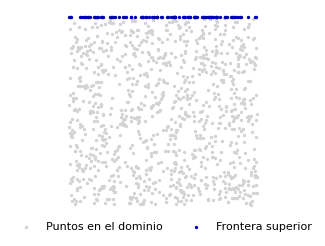

In [128]:
# Visualization
plt.figure(figsize=(3.5, 2.5))
plt.scatter(pts[:, 0], pts[:, 1], s=2, c='lightgray', label='Puntos en el dominio')
plt.scatter(pts_top[:, 0], pts_top[:, 1], s=2, c="#0003B4", label='Frontera superior')
 
plt.axis('equal')
plt.axis('off')

# Legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig('domain_points.svg', dpi=300)
plt.savefig('domain_points.pdf', dpi=300)
plt.show()

## Material and loading definition

In [82]:
nu = 0.3               # Poisson's ratio
T = 1.0                # Traction on right edge
E = torch.ones((N_total, 1), device=device)  # Young's modulus field (homogeneous)

## Build the Neural Network

The neural network is designed to predict the 2D displacement field:
\begin{equation}
    \mathbf{u}(x, y) =
    \begin{bmatrix}
        u(x, y) \\[3pt]
        v(x, y)
    \end{bmatrix},
\end{equation}
where $u(x, y)$ and $v(x, y)$ denote the horizontal and vertical displacement components, respectively.

To ensure that the essential (Dirichlet) boundary conditions are exactly satisfied, we incorporate **hard constraints** directly into the neural network architecture. 

On the **bottom boundary** ($y = 0$), both displacements vanish ($u = v = 0$).  

The hard constraints are introduced by defining the predicted displacement field as:
\begin{align}
    \tilde{u}(x, y) &= y \, \hat{u}(x, y), \\[4pt]
    \tilde{v}(x, y) &= y \, \hat{v}(x, y),
\end{align}
where $\hat{u}(x, y)$ and $\hat{v}(x, y)$ are the unconstrained outputs of the neural network.  



In [83]:
net_uv = Net2D(n_input=2, n_output=2, n_layer=2, n_nodes=275).to(device)

# Hard boundary condition: u = v = 0 on y = 0
def uv_tilde(pt):
    ycoord = pt[:, 0:1]           # extract y-coordinate
    out = net_uv(pt)
    return ycoord * out           # ensures u=v=0 when y=0

## Loss configuration

The total potential energy of a deformable body is given by:
\begin{equation}
    \Pi(u) = E_{\text{int}} + E_{\text{ext}},
\end{equation}
where $E_{\text{int}}$ is the internal strain energy and $E_{\text{ext}}$ is the potential energy associated with the external forces.

In two dimensions:
\begin{align}
    \varepsilon_{xx} &= \frac{\partial u}{\partial x}, \\[3pt]
    \varepsilon_{yy} &= \frac{\partial v}{\partial y}, \\[3pt]
    \gamma_{xy} &= \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}.
\end{align}

For a linear elastic, plane stress material, the Cauchy stress components are:
\begin{align}
    \sigma_{xx} &= \lambda (\varepsilon_{xx} + \varepsilon_{yy}) + 2\mu \varepsilon_{xx}, \\[3pt]
    \sigma_{yy} &= \lambda (\varepsilon_{xx} + \varepsilon_{yy}) + 2\mu \varepsilon_{yy}, \\[3pt]
    \tau_{xy} &= \mu \gamma_{xy},
\end{align}
where the Lamé parameters are defined as:
\begin{equation}
    \lambda = \frac{E\nu}{1 - \nu^2}, \quad 
    \mu = \frac{E}{2(1 + \nu)}.
\end{equation}

 

The internal strain energy is:
\begin{equation}
    E_{\text{int}} = 
    \frac{1}{2} \int_{\Omega} \left(
        \sigma_{xx} \varepsilon_{xx} +
        \sigma_{yy} \varepsilon_{yy} +
        \tau_{xy} \gamma_{xy}
    \right) \, dV.
\end{equation}


In the PINN implementation, the domain $\Omega$ is discretized by a set of $N_\Omega$ collocation points 
$\{(x_i, y_i)\}_{i=1}^{N_\Omega}$.  
The integral is approximated by the mean of the integrand over these points:
\begin{equation}
    \int_{\Omega} f(x,y)\, dV 
    \approx 
    \frac{1}{N_\Omega} \sum_{i=1}^{N_\Omega} f(x_i, y_i),
\end{equation}
so that
\begin{equation}
    E_{\text{int}} \approx 
    \frac{1}{N_\Omega} \sum_{i=1}^{N_\Omega} \left(
        \sigma_{xx} \varepsilon_{xx} +
        \sigma_{yy} \varepsilon_{yy} +
        \tau_{xy} \gamma_{xy}
    \right).
\end{equation}

Similarly, the external potential energy over the traction boundary $\partial \Omega_t$
is approximated using $N_t$ boundary points $\{(x_j, y_j)\}_{j=1}^{N_t}$:
\begin{equation}
    E_{\text{ext}} =
    -\int_{\partial \Omega_t} \mathbf{T}^T \mathbf{u} \, dA
    \approx
    -\frac{1}{N_t}
    \sum_{j=1}^{N_t} \mathbf{T}^T \mathbf{u}(x_j, y_j).
\end{equation}



The total potential energy, which acts as the PINN loss function, is therefore:
\begin{equation}
    \mathcal{L}_{\text{energy}} = \Pi(u) = E_{\text{int}} + E_{\text{ext}}.
\end{equation}

 


In [84]:
def energy_loss(data, uv_tilde, E, nu, T, top_idx_t):

    # Network prediction: displacement field
    uv = uv_tilde(data)
    u, v = uv[:, 0:1], uv[:, 1:2]   # components of displacement

    # Strain tensor ε (Eq. 3)
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]

    du_dx, du_dy = du[:, 0:1], du[:, 1:2]
    dv_dx, dv_dy = dv[:, 0:1], dv[:, 1:2]

    eps_xx = du_dx
    eps_yy = dv_dy
    gamma_xy = du_dy + dv_dx   # engineering shear strain (ε_xy + ε_yx)

    # Constitutive law (plane stress)  
    mu = E / (2.0 * (1.0 + nu))                         # shear modulus
    lam = E * nu / (1.0 - nu**2)                        # Lamé parameter for plane stress

    sigma_xx = lam * (eps_xx + eps_yy) + 2.0 * mu * eps_xx
    sigma_yy = lam * (eps_xx + eps_yy) + 2.0 * mu * eps_yy
    tau_xy   = mu * gamma_xy

    # Internal strain energy density  
    W_int = 0.5 * (sigma_xx * eps_xx + sigma_yy * eps_yy + tau_xy * gamma_xy)
    E_int = torch.mean(W_int)   # ⟨W_int⟩ over Ω

    # External potential energy  
    v_top = v[top_idx_t]
    E_ext = - T * torch.mean(v_top)   # negative sign: work of external forces

    # Total potential energy  
    Pi_total = E_int + E_ext

    return Pi_total, E_int, E_ext

## Training phase

In [85]:
epochs = 1_001
lr = 1e-3
optimizer = torch.optim.Adam(net_uv.parameters(), lr=lr)
loss_history = []

print("\n=====================")
print(" Adam Training")
print("=====================")
start = time.time()

for ep in range(epochs):
    optimizer.zero_grad()
    loss, Eint, Eext = energy_loss(data, uv_tilde, E, nu, T, top_idx_t)

    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)
    if ep % 200 == 0 or ep == epochs - 1:
        print(f"Epoch {ep:5d}/{epochs} | loss={loss_val:.6e} | Eint={Eint.item():.4e} | Eext={Eext.item():.4e}")

print(f"Adam training completed in {(time.time()-start):.2f} s")


 Adam Training
Epoch     0/1001 | loss=1.636179e-02 | Eint=6.3389e-03 | Eext=1.0023e-02
Epoch   200/1001 | loss=-7.918238e-01 | Eint=7.8290e-01 | Eext=-1.5747e+00
Epoch   400/1001 | loss=-8.945438e-01 | Eint=8.7174e-01 | Eext=-1.7663e+00
Epoch   600/1001 | loss=-9.084890e-01 | Eint=8.9246e-01 | Eext=-1.8009e+00
Epoch   800/1001 | loss=-9.145800e-01 | Eint=9.0602e-01 | Eext=-1.8206e+00
Epoch  1000/1001 | loss=-9.129648e-01 | Eint=9.5200e-01 | Eext=-1.8650e+00
Adam training completed in 4.26 s


In [86]:
torch.save(net_uv.state_dict(), "modelo_final.pt")
print("\nModelo guardado como 'modelo_final.pt'")



Modelo guardado como 'modelo_final.pt'


In [88]:
# Load the trained model
net_uv = Net2D(n_input=2, n_output=2, n_layer=2, n_nodes=275).to(device)
net_uv.load_state_dict(torch.load("modelo_final.pt", map_location=device))
net_uv.eval()

Net2D(
  (input): Linear(in_features=2, out_features=275, bias=True)
  (hidden): ModuleList(
    (0-1): 2 x Linear(in_features=275, out_features=275, bias=True)
  )
  (output): Linear(in_features=275, out_features=2, bias=True)
)

In [89]:
# --- Crear grid uniforme ---
nx, ny = 50, 50   # resolución del grid (elige la que quieras)

x_min, x_max = 0.0, 1.0   # límites del dominio en x
y_min, y_max = 0.0, 1.0   # límites del dominio en y

x_lin = torch.linspace(x_min, x_max, nx)
y_lin = torch.linspace(y_min, y_max, ny)
X, Y = torch.meshgrid(x_lin, y_lin, indexing='xy')

grid = torch.stack([X.flatten(), Y.flatten()], dim=1)  # (N, 2)

# --- Pasar por el modelo ---
net_uv.eval()
uv_pred =  uv_tilde(grid.to(device))   # (N, 2)

# --- Separar desplazamientos ---
u_pred = uv_pred[:, 0].reshape(nx, ny)
v_pred = uv_pred[:, 1].reshape(nx, ny)

## Visualization

/tmp/ipykernel_1354/1285761658.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


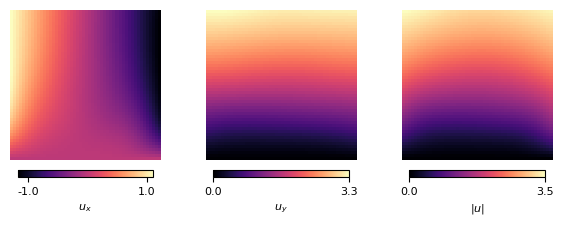

In [124]:
from matplotlib import gridspec

# --- Figure & GridSpec ---
fig = plt.figure(figsize=(7.0, 2.5))
gs = gridspec.GridSpec(
    1, 3,
    width_ratios=[1,1,1],
    wspace=0.3
)

# --- Convert tensors ---
u_np = u_pred.detach().cpu().numpy()
v_np = v_pred.detach().cpu().numpy()
disp_norm = np.sqrt(u_np**2 + v_np**2)

cmap = "magma"

# --- ticks extremos ---
ticks_u    = [-1, 1]
ticks_v    = [v_np.min(), v_np.max()]
ticks_norm = [disp_norm.min(), disp_norm.max()]

# ---------- u(x,y) ----------
ax0 = fig.add_subplot(gs[0])
pm0 = ax0.pcolormesh(
    X, Y, u_np.T,
    cmap=cmap,
    shading="auto",     # para evitar warnings
    vmin=u_np.min(), vmax=u_np.max(),
    rasterized=True
)
ax0.set_aspect("equal")
ax0.axis('off')

cbar0 = plt.colorbar(
    pm0, ax=ax0,
    orientation="horizontal",
    pad=0.05, shrink=0.9,
    ticks=ticks_u, format="%.1f"
)
cbar0.set_label(r"$u_{x}$")


# ---------- v(x,y) ----------
ax1 = fig.add_subplot(gs[1])
pm1 = ax1.pcolormesh(
    X, Y, v_np.T,
    cmap=cmap,
    shading="auto",
    vmin=v_np.min(), vmax=v_np.max(),
    rasterized=True
)
ax1.set_aspect("equal")
ax1.axis('off')

cbar1 = plt.colorbar(
    pm1, ax=ax1,
    orientation="horizontal",
    pad=0.05, shrink=0.9,
    ticks=ticks_v, format="%.1f"
)
cbar1.set_label(r"$u_{y}$")

# ---------- |u| ----------
ax2 = fig.add_subplot(gs[2])
pm2 = ax2.pcolormesh(
    X, Y, disp_norm.T,
    cmap=cmap,
    shading="auto",
    vmin=disp_norm.min(), vmax=disp_norm.max(),
    rasterized=True
)
ax2.set_aspect("equal")
ax2.axis('off')

cbar2 = plt.colorbar(
    pm2, ax=ax2,
    orientation="horizontal",
    pad=0.05, shrink=0.9,
    ticks=ticks_norm, format="%.1f"
)
cbar2.set_label(r"$|u|$")

plt.tight_layout()
plt.savefig("displacement_fields.svg", dpi=300)
plt.savefig("displacement_fields.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [106]:
def compute_strains_and_magnitude(u, v, x, y):
    """
    u, v: funciones que dependen de (x,y) → tensores que requieren grad.
    x, y: tensores (iguales tamaño) con grad_enabled=True
    """
    grads_u = torch.autograd.grad(u, (x, y), grad_outputs=torch.ones_like(u), create_graph=True)
    grads_v = torch.autograd.grad(v, (x, y), grad_outputs=torch.ones_like(v), create_graph=True)

    u_x, u_y = grads_u
    v_x, v_y = grads_v

    eps_xx = u_x
    eps_yy = v_y
    gamma_xy = u_y + v_x

    mag_u = torch.sqrt(u**2 + v**2)

    return eps_xx, eps_yy, gamma_xy, mag_u


In [107]:
def compute_stress_plane_stress(eps_xx, eps_yy, gamma_xy, E, nu):
    coef = E / (1 - nu**2)
    sigma_xx = coef * (eps_xx + nu * eps_yy)
    sigma_yy = coef * (eps_yy + nu * eps_xx)
    tau_xy   = E / (2 * (1 + nu)) * gamma_xy
    return sigma_xx, sigma_yy, tau_xy


In [ ]:
 
# Requieren grad
xg = grid[:, 0].reshape(-1, 1).clone().detach().requires_grad_(True)
yg = grid[:, 1].reshape(-1, 1).clone().detach().requires_grad_(True)

# --- Paso por la red ---
net_uv.eval()
uv_pred = uv_tilde(torch.cat([xg, yg], dim=1))

u = uv_pred[:, 0:1]
v = uv_pred[:, 1:2]

# --- Deformaciones ---
eps_xx, eps_yy, gamma_xy, _ = compute_strains_and_magnitude(u, v, xg, yg)

# --- Tensiones (plane stress) ---
E  = 210e9        # ejemplo
nu = 0.3

sigma_xx, sigma_yy, tau_xy = compute_stress_plane_stress(
    eps_xx, eps_yy, gamma_xy, E, nu
)

# --- Mapas ---
σxx_map = sigma_xx.reshape(nx, ny)
σyy_map = sigma_yy.reshape(nx, ny)
txy_map = tau_xy.reshape(nx, ny)


/tmp/ipykernel_1354/2430847013.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


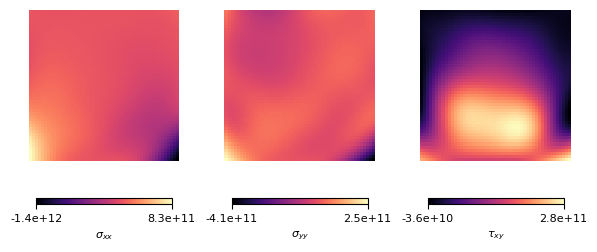

In [114]:
# ============================
#   MAPAS DE TENSIONES
# ============================
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

# --- Convertir tensiones a numpy ---
σxx_np = sigma_xx.detach().cpu().numpy().reshape(nx, ny)
σyy_np = sigma_yy.detach().cpu().numpy().reshape(nx, ny)
txy_np = tau_xy.detach().cpu().numpy().reshape(nx, ny)

cmap = "magma"

# --- ticks extremos (opcional) ---
ticks_xx = [σxx_np.min(), σxx_np.max()]
ticks_yy = [σyy_np.min(), σyy_np.max()]
ticks_xy = [txy_np.min(), txy_np.max()]

# --- Figure & GridSpec ---
fig = plt.figure(figsize=(7.0, 3.2))
gs = gridspec.GridSpec(
    1, 3,
    width_ratios=[1,1,1],
    wspace=0.3
)

# =========== σxx ===========
ax0 = fig.add_subplot(gs[0])
pm0 = ax0.pcolormesh(
    X, Y, σxx_np.T,
    cmap=cmap,
    shading="auto",
    vmin=σxx_np.min(), vmax=σxx_np.max(),
    rasterized=True
)
ax0.set_aspect("equal")
ax0.axis('off')

cbar0 = plt.colorbar(
    pm0, ax=ax0,
    orientation="horizontal",
    pad=0.15, shrink=0.9,
    ticks=ticks_xx, format="%.1e"
)
cbar0.set_label(r"$\sigma_{xx}$")

# =========== σyy ===========
ax1 = fig.add_subplot(gs[1])
pm1 = ax1.pcolormesh(
    X, Y, σyy_np.T,
    cmap=cmap,
    shading="auto",
    vmin=σyy_np.min(), vmax=σyy_np.max(),
    rasterized=True
)
ax1.set_aspect("equal")
ax1.axis('off')

cbar1 = plt.colorbar(
    pm1, ax=ax1,
    orientation="horizontal",
    pad=0.15, shrink=0.9,
    ticks=ticks_yy, format="%.1e"
)
cbar1.set_label(r"$\sigma_{yy}$")

# =========== τxy ===========
ax2 = fig.add_subplot(gs[2])
pm2 = ax2.pcolormesh(
    X, Y, txy_np.T,
    cmap=cmap,
    shading="auto",
    vmin=txy_np.min(), vmax=txy_np.max(),
    rasterized=True
)
ax2.set_aspect("equal")
ax2.axis('off')

cbar2 = plt.colorbar(
    pm2, ax=ax2,
    orientation="horizontal",
    pad=0.15, shrink=0.9,
    ticks=ticks_xy, format="%.1e"
)
cbar2.set_label(r"$\tau_{xy}$")

plt.tight_layout()
plt.savefig("stress_fields.svg", dpi=300)
plt.savefig("stress_fields.pdf", dpi=300)
plt.show()
